## Лабораторная работа №1 по системам обработки больших данных

### Импортирование модулей

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from functools import reduce
from pyspark.sql import functions 
from pyspark.sql.types import *

MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab1") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

filename_data = 'data/the-reddit-covid-dataset-comments.csv'
df = spark.read.csv(filename_data, mode="DROPMALFORMED")

filename_data = 'data/the-reddit-covid-dataset-comments.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)

Columns overview


,Column Name,Data type
0,_c0,string
1,_c1,string
2,_c2,string
3,_c3,string
4,_c4,string
5,_c5,string
6,_c6,string
7,_c7,string
8,_c8,string
9,_c9,string


In [4]:
new_column_names = {
    "_c0": "type",
    "_c1": "id",
    "_c2": "subreddit_id",
    "_c3": "subreddit_name",
    "_c4": "subreddit_nsfw",
    "_c5": "created_utc",
    "_c6": "permalink",
    "_c7": "body",
    "_c8": "sentiment",
    "_c9": "score",
}

for c, new_c in new_column_names.items():
    df = df.withColumnRenamed(c, new_c)

df = df.withColumn("subreddit_nsfw", col("subreddit_nsfw").cast(BooleanType()))
df = df.withColumn("sentiment", col("sentiment").cast(FloatType()))
df = df.withColumn("score", col("score").cast(IntegerType()))

df.printSchema()
df.show()

root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- subreddit_name: string (nullable = true)
 |-- subreddit_nsfw: boolean (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: float (nullable = true)
 |-- score: integer (nullable = true)

+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit_id|      subreddit_name|subreddit_nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit.id|      subreddit.name|          NULL|created_utc|           permalink|                body|     NULL| NULL|
|comment|hi1vsag|       2riyy|           

In [5]:
df.count()

50909730

In [6]:
df = df.filter(reduce(lambda x, y: x & col(y).isNotNull(), df.columns, lit(True)))

In [7]:
quantiles = df.approxQuantile("score", [0.25, 0.75], 0)
IQR = quantiles[1] - quantiles[0]
lower_bound = quantiles[0] - 1.5 * IQR
upper_bound = quantiles[1] + 1.5 * IQR
df = df.filter(col("score").between(lower_bound, upper_bound))


In [8]:
df.count()

7246389

<Figure size 640x480 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7feb4cb8fed0>,
 'caps': [<matplotlib.lines.Line2D at 0x7feb4b9ed710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feb4cb8ee50>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb4b9ef090>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feb4b9efd50>],
 'means': []}

Text(0.5, 1.0, 'Score')

Text(0, 0.5, 'Values')

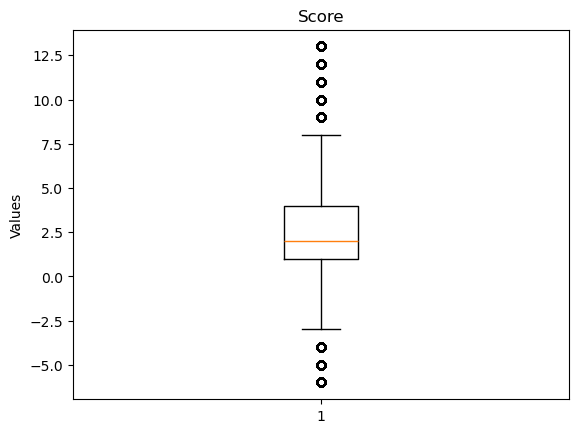

In [9]:
score_df = df.select("score")
pd_score_df = score_df.toPandas()
plt.figure()
plt.boxplot(pd_score_df['score'])
plt.title('Score')
plt.ylabel('Values')
plt.show()

In [10]:
df.show(20)

+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit_id|      subreddit_name|subreddit_nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|comment|hi1vsag|       2riyy|                nova|         false| 1635206399|https://old.reddi...|When you schedule...|      0.0|    2|
|comment|hi1vs0l|       2qsf3|             ontario|         false| 1635206395|https://old.reddi...|Compare BC to Ont...|      0.0|   -2|
|comment|hi1vrou|       384mz|         antivaxxers|         false| 1635206391|https://old.reddi...|I don’t know anyo...|  -0.9191|    1|
|comment|hi1vrg2|       2qh4r|          conspiracy|         false| 1635206388|https://old.reddi...|BS. Not a fear ca...|  -0.9625|    1|
|comment|hi1vre5|       2s5sb|      toron

In [16]:
quantiles = df.approxQuantile("score", [0.5], 0.05)
median_score = quantiles[0]
print("Median score:", median_score)
df.select('score').describe().show()

Median score: 2.0
+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           7246389|
|   mean|2.7436935831073934|
| stddev| 3.094239621525104|
|    min|                -6|
|    max|                13|
+-------+------------------+



**count** - Количество строк\
**mean** - Среднее значение\
**stddev** - Стандартное отклонение\
**min** - Минимальное значение\
**max** - Максимальное значение